In [3]:
import pandas as pd
#import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
#import shapely
import math
import os
from collections import OrderedDict
from EM_Tomo_viz_tools import *
from Create_vector_grid import *
%matplotlib inline
pd.options.mode.chained_assignment = None


In [4]:
#Settings:
#check for 3D data only, 2D cannot be worked on
#change to height at -3
#add crs to grid_data and output
#throw out all no-data rows
#Multiple depths
height = -3
no_data_value = float('Nan')

input_file2 = "/Users/kazv/VanBovenDrive/VanBoven MT/500 Projects/P2 Wiertsema/data/3D_compleet.shp"
output_file2 = "/Users/kazv/VanBovenDrive/VanBoven MT/500 Projects/P2 Wiertsema/data/Test_output.shp"


In [20]:
#Read and upgrade basic GDF:
gdf = read_shapefile(input_file2)
gdf['top'] = gdf.elev_boven
gdf['bottom'] = gdf.elev_boven+gdf.Dikte


In [43]:
# if not(isinstance(filetext, str)) || not(isinstance(output_foldertext, str)):
    
    
    
filetext = ''
output_foldertext = 2

if not(isinstance(filetext,str)) or not(isinstance(output_foldertext,str)):
    print('yes')
else:
    print('no')

yes


In [21]:
#Filter for the right depth and create new GDF with 'Meetlocatie' ID as index
gdf_filtered = gdf[(gdf.top> height) & (gdf.bottom <= height)]
gdf_filtered['Punt_ID_num'] = gdf_filtered.Punt_ID.apply(lambda x: int(x[x.find('_')+1::]))
gdf_filtered.sort_values('Punt_ID_num', inplace=True)
gdf_filtered.set_index('Punt_ID_num', drop=True, inplace=True)
gdf_filtered.drop('Punt_ID',1,inplace=True)

#Determine grid size by using distance between measurements
gdf_filtered['dist_to_next'] = gdf_filtered.distance(gdf_filtered.shift(1))
grid_size = int(gdf_filtered.dist_to_next.median())+1 #+1 to make sure we slightly over-sample

In [44]:
#Create the grid
xmin,ymin,xmax,ymax = gdf_filtered.geometry.total_bounds

length = grid_size
wide = grid_size

cols = list(range(int(np.floor(xmin)-wide), int(np.ceil(xmax)+wide), wide))
rows = list(range(int(np.floor(ymin)-length), int(np.ceil(ymax)+length), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.crs = gdf_filtered.crs
#translate grid so that points fall in the center instead of at the boundaries
grid.geometry = grid.geometry.translate(xoff=int(grid_size/2), yoff=int(grid_size/2))

NameError: name 'gdf_filtered' is not defined

In [23]:
#Join raster with measurement points to find out which points lie in every raster element
joined_raster_data = gpd.sjoin(grid,gdf_filtered, how="left")

In [24]:
grid_data = gpd.GeoDataFrame()
grid_data['geometry'] = grid.geometry
grid_data['IDs'] = joined_raster_data.groupby(joined_raster_data.index).index_right.apply(list)
grid_data['has_data'] = grid_data.IDs.apply(lambda x: x[0] == x[0])
grid_data['EC'] = no_data_value
grid_data['height'] = height
grid_data.crs = gdf_filtered.crs


In [25]:
#Determine right 'average' EC value, based on proximity to centroid.
#This could be extended to include empty as well by interpolation.
#TODO: Add concave hull boundary to detect which 'novalues' should remain 'novalue' and interpolate the others.
for ii in range(1,len(grid_data)):
    line = grid_data.iloc[ii]
    if line.has_data:
        id_list = line.IDs
        #Get all measurements within the square
        this_square_df =gdf_filtered[gdf_filtered.index.isin(id_list)]
        centroid = line.geometry.centroid
        #Determine distance (and inverse) to centroid
        this_square_df['dist_to_centroid'] = this_square_df.geometry.distance(centroid)
        this_square_df['closeness'] = 1/this_square_df.dist_to_centroid
        #take weighted average of EC with respect to closeness to centroid. 
        #The closer the higher its weighted in a linear fashion.
        this_square_df['weighted_EC'] = this_square_df.EC * this_square_df.closeness
        weighted_avg_EC = this_square_df.weighted_EC.sum()/this_square_df.closeness.sum()
        grid_data['EC'][grid_data.index==ii] = weighted_avg_EC


In [26]:
#generate requested output
#add EPSG 28992
output = grid_data[['geometry','EC','height']][grid_data.has_data]
output.crs = gdf_filtered.crs
output.to_file(driver = 'ESRI Shapefile', filename = output_file2)

/Users/kazv/miniconda3/envs/wiertsema/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


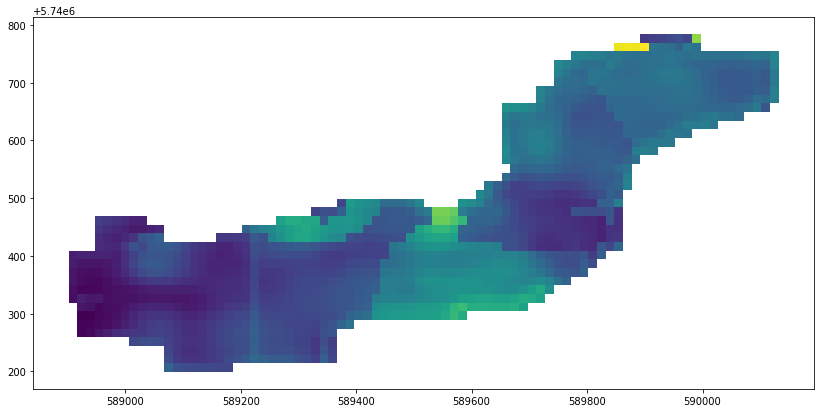

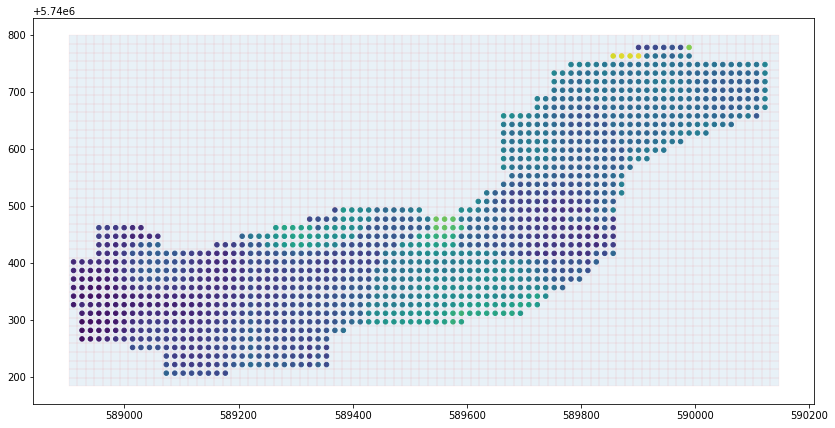

In [27]:
#Optional plotting for reference
grid_data[grid_data.EC>0].plot(column = 'EC', figsize=(14,10))
data_plot = gdf_filtered.plot(column='EC', markersize=20, figsize=(14,10))
grid.plot(ax=data_plot,alpha=0.1, edgecolor="red", linewidth=0.4)

In [26]:
output

,geometry,EC,depth
0,"POLYGON ((588902 5740799, 588917 5740799, 5889...",NaN,3
1,"POLYGON ((588902 5740784, 588917 5740784, 5889...",NaN,3
2,"POLYGON ((588902 5740769, 588917 5740769, 5889...",NaN,3
3,"POLYGON ((588902 5740754, 588917 5740754, 5889...",NaN,3
4,"POLYGON ((588902 5740739, 588917 5740739, 5889...",NaN,3
5,"POLYGON ((588902 5740724, 588917 5740724, 5889...",NaN,3
6,"POLYGON ((588902 5740709, 588917 5740709, 5889...",NaN,3
7,"POLYGON ((588902 5740694, 588917 5740694, 5889...",NaN,3
8,"POLYGON ((588902 5740679, 588917 5740679, 5889...",NaN,3
9,"POLYGON ((588902 5740664, 588917 5740664, 5889...",NaN,3


In [28]:
grid_data[grid_data.has_data]

,geometry,IDs,has_data,EC,depth
26,"POLYGON ((588902 5740409, 588917 5740409, 5889...",[529.0],True,122.39,3
27,"POLYGON ((588902 5740394, 588917 5740394, 5889...",[467.0],True,121.48,3
28,"POLYGON ((588902 5740379, 588917 5740379, 5889...",[406.0],True,115.71,3
29,"POLYGON ((588902 5740364, 588917 5740364, 5889...",[347.0],True,114.18,3
30,"POLYGON ((588902 5740349, 588917 5740349, 5889...",[290.0],True,110.46,3
31,"POLYGON ((588902 5740334, 588917 5740334, 5889...",[234.0],True,107.47,3
67,"POLYGON ((588917 5740409, 588932 5740409, 5889...",[530.0],True,126.24,3
68,"POLYGON ((588917 5740394, 588932 5740394, 5889...",[468.0],True,115.06,3
69,"POLYGON ((588917 5740379, 588932 5740379, 5889...",[407.0],True,108.74,3
70,"POLYGON ((588917 5740364, 588932 5740364, 5889...",[348.0],True,107.50,3
